# ✈️ Flight Delay Prediction – Santiago Airport (SCL)
This project aims to predict the probability of a flight being delayed by more than 15 minutes using flight data from Santiago de Chile International Airport (SCL) during 2017.

## 📘 Variable Dictionary
### 🛫 Raw flight data
- fecha_i: Scheduled departure date and time
- vlo_i: Scheduled flight number
- ori_i: Origin airport IATA code (scheduled)
- des_i: Destination airport IATA code (scheduled)
- emp_i: Airline IATA code (scheduled)
- fecha_o: Actual departure date and time
- vlo_o: Actual flight number
- ori_o: Origin airport IATA code (actual)
- des_o: Destination airport IATA code (actual)
- emp_o: Airline IATA code (actual)
- dia: Day of the month (1–31)
- mes: Month of the year (1–12)
- año: Year (should be 2017 for all records)
- dianom: Day of the week (in Spanish, e.g., Lunes, Martes, etc.)
- tipovuelo: Flight type: N for domestic, I for international
- opera: Full name of the operating airline
- siglaori: City name of the origin airport
- siglades: City name of the destination airport

### 🛠️ Engineered features (after preprocessing)
- min_diff: Time difference in minutes between actual and scheduled departure
- delay_15: Target variable: 1 if min_diff > 15, else 0
- high_season: 1 if flight occurs during Chilean high season, otherwise 0
- period_day: Time of day bucket: morning, afternoon, evening, or night

In [1]:
import os
import sys

%load_ext autoreload
%autoreload 2

# Add project root to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))


In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
from src.data.load_data import load_raw_data
from src.data.preprocess import parse_dates, clean_column_names
from src.features.build_features import build_synthetic_features
from src.visualization.visualize import (
    plot_delay_rate_by_column,
    plot_count_by_column,
    plot_delay_distribution,
    plot_delay_rate_by_two_categories
)

## 📥 Data Loading and Initial Inspection

In [3]:
# Load and prepare data
df = load_raw_data()
df = parse_dates(df)
df = clean_column_names(df)

# Preview
df.head()

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


## 🔍 Data Overview

In [4]:
df.info()
df.describe(include='all')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha_i    68206 non-null  datetime64[ns]
 1   vlo_i      68206 non-null  object        
 2   ori_i      68206 non-null  object        
 3   des_i      68206 non-null  object        
 4   emp_i      68206 non-null  object        
 5   fecha_o    68206 non-null  datetime64[ns]
 6   vlo_o      68205 non-null  object        
 7   ori_o      68206 non-null  object        
 8   des_o      68206 non-null  object        
 9   emp_o      68206 non-null  object        
 10  dia        68206 non-null  int64         
 11  mes        68206 non-null  int64         
 12  año        68206 non-null  int64         
 13  dianom     68206 non-null  object        
 14  tipovuelo  68206 non-null  object        
 15  opera      68206 non-null  object        
 16  siglaori   68206 non-null  object       

fecha_i      0
vlo_i        0
ori_i        0
des_i        0
emp_i        0
fecha_o      0
vlo_o        1
ori_o        0
des_o        0
emp_o        0
dia          0
mes          0
año          0
dianom       0
tipovuelo    0
opera        0
siglaori     0
siglades     0
dtype: int64

## 🛠️ Feature Engineering

In [5]:
# Drop the single row with missing vlo_o (optional: could also impute)
df = df[df["vlo_o"].notna()].copy()

# Create delay in minutes between scheduled and actual departure
df["min_diff"] = (df["fecha_o"] - df["fecha_i"]).dt.total_seconds() / 60

# Create binary target: delay greater than 15 minutes
df["delay_15"] = (df["min_diff"] > 15).astype(int)

# Check results
df[["fecha_i", "fecha_o", "min_diff", "delay_15"]].head()


,fecha_i,fecha_o,min_diff,delay_15
0,2017-01-01 23:30:00,2017-01-01 23:33:00,3.0,0
1,2017-01-02 23:30:00,2017-01-02 23:39:00,9.0,0
2,2017-01-03 23:30:00,2017-01-03 23:39:00,9.0,0
3,2017-01-04 23:30:00,2017-01-04 23:33:00,3.0,0
4,2017-01-05 23:30:00,2017-01-05 23:28:00,-2.0,0


In [6]:
df = build_synthetic_features(df)

# Preview engineered features
df[["fecha_i", "fecha_o", "min_diff", "delay_15", "high_season", "period_day"]].head()


,fecha_i,fecha_o,min_diff,delay_15,high_season,period_day
0,2017-01-01 23:30:00,2017-01-01 23:33:00,3.0,0,1,night
1,2017-01-02 23:30:00,2017-01-02 23:39:00,9.0,0,1,night
2,2017-01-03 23:30:00,2017-01-03 23:39:00,9.0,0,1,night
3,2017-01-04 23:30:00,2017-01-04 23:33:00,3.0,0,1,night
4,2017-01-05 23:30:00,2017-01-05 23:28:00,-2.0,0,1,night


## 📊 Exploratory Data Analysis (EDA)

c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, order=order, palette="Blues")


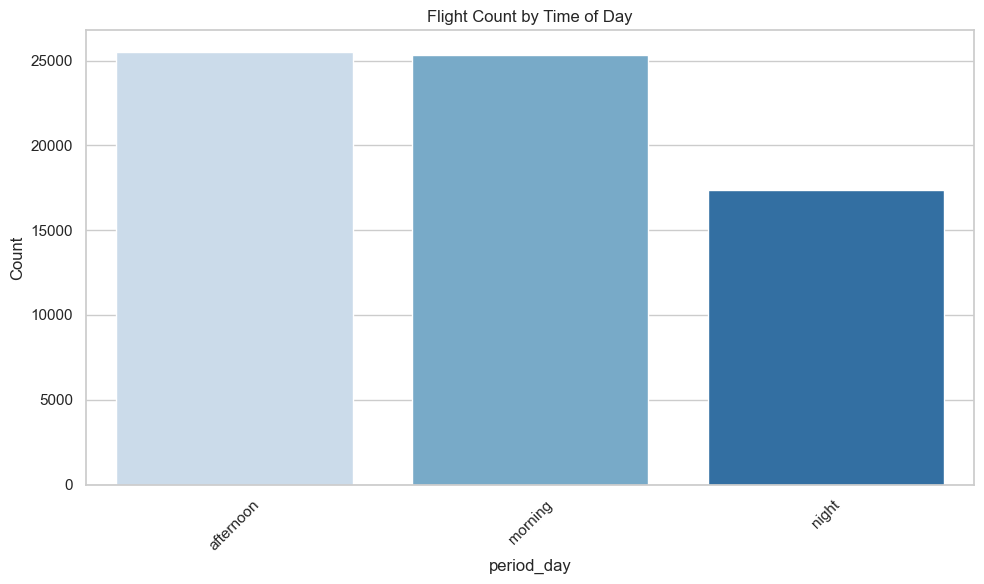

In [7]:
from src.visualization.visualize import plot_count_by_column

plot_count_by_column(df, "period_day", title="Flight Count by Time of Day")


c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  figsize : tuple, optional


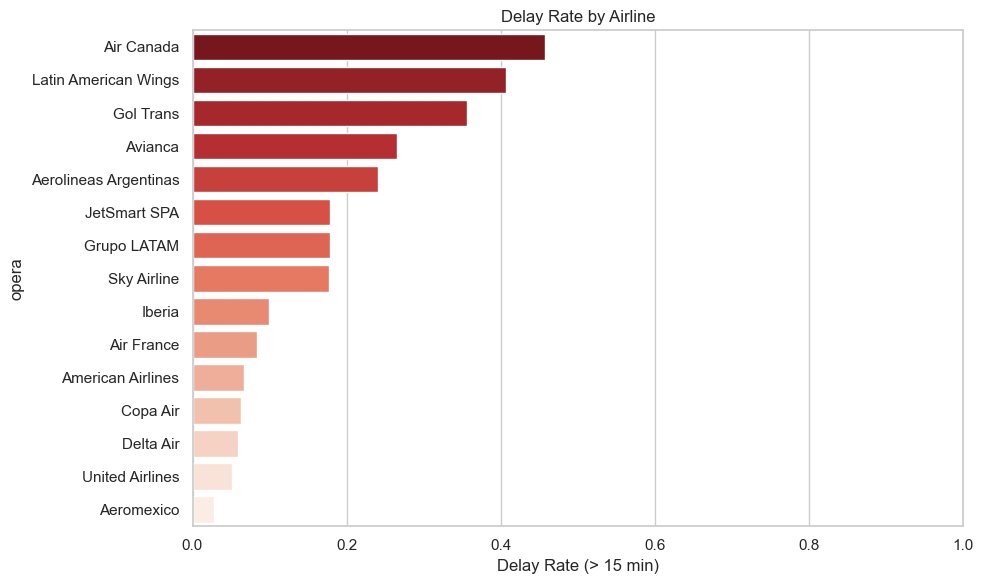

c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  figsize : tuple, optional


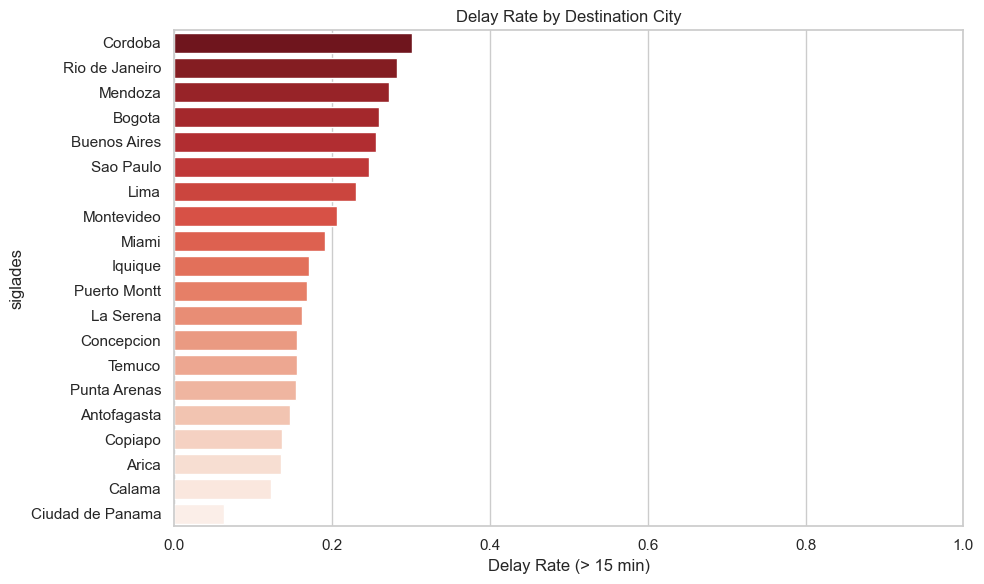

c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  figsize : tuple, optional


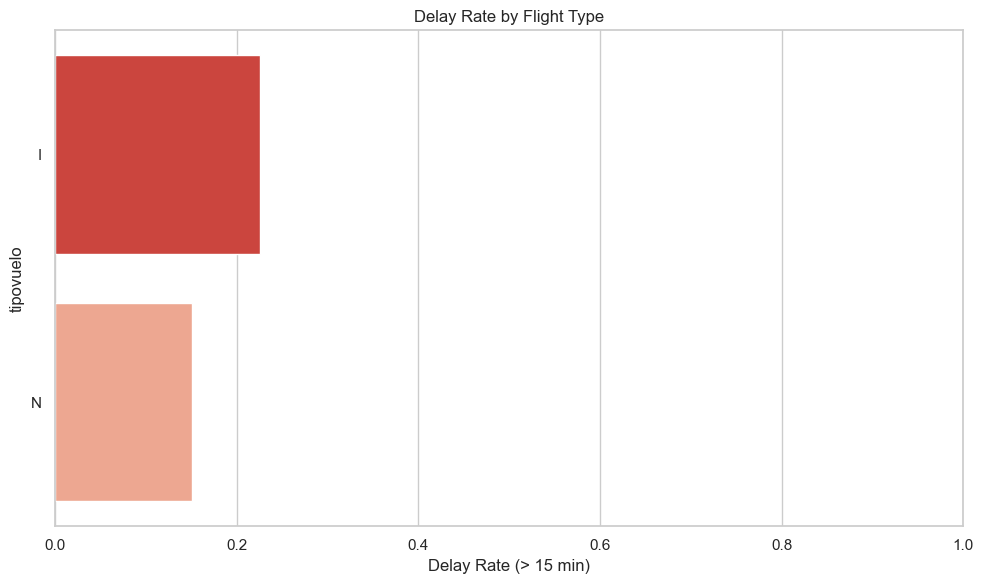

In [9]:
from src.visualization.visualize import plot_delay_rate_by_column

plot_delay_rate_by_column(df, "opera", top_n=15, title="Delay Rate by Airline")
plot_delay_rate_by_column(df, "siglades", top_n=20, title="Delay Rate by Destination City")
plot_delay_rate_by_column(df, "tipovuelo", title="Delay Rate by Flight Type")


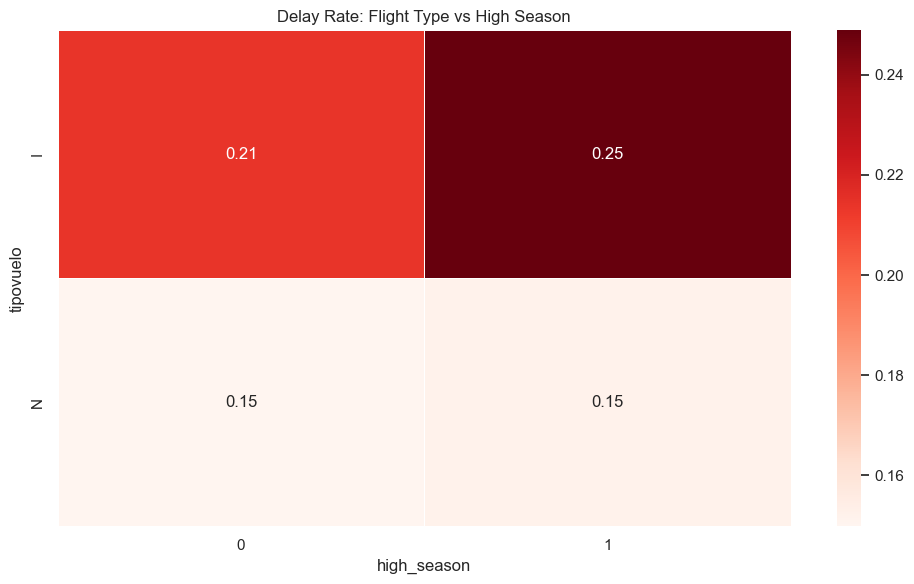

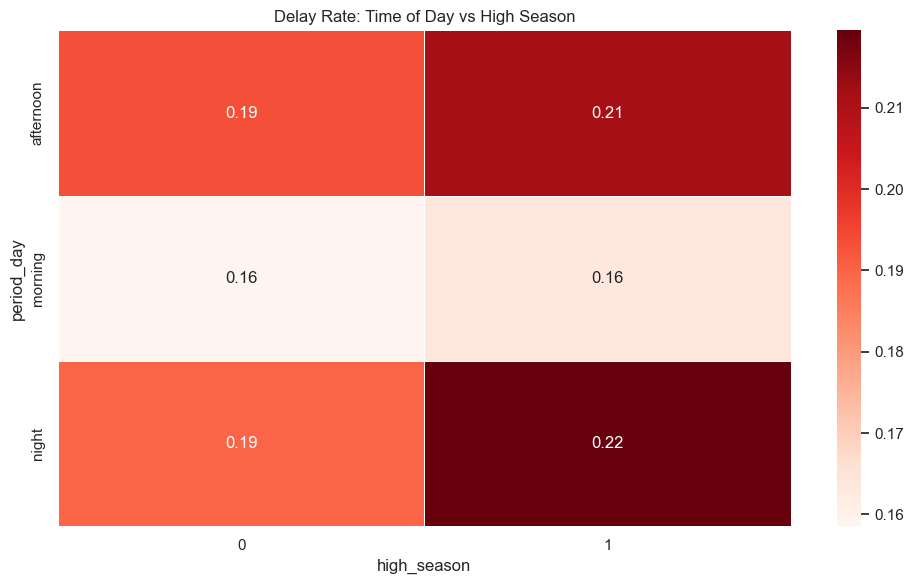

In [10]:
from src.visualization.visualize import plot_delay_rate_by_two_categories

plot_delay_rate_by_two_categories(df, "tipovuelo", "high_season", title="Delay Rate: Flight Type vs High Season")
plot_delay_rate_by_two_categories(df, "period_day", "high_season", title="Delay Rate: Time of Day vs High Season")


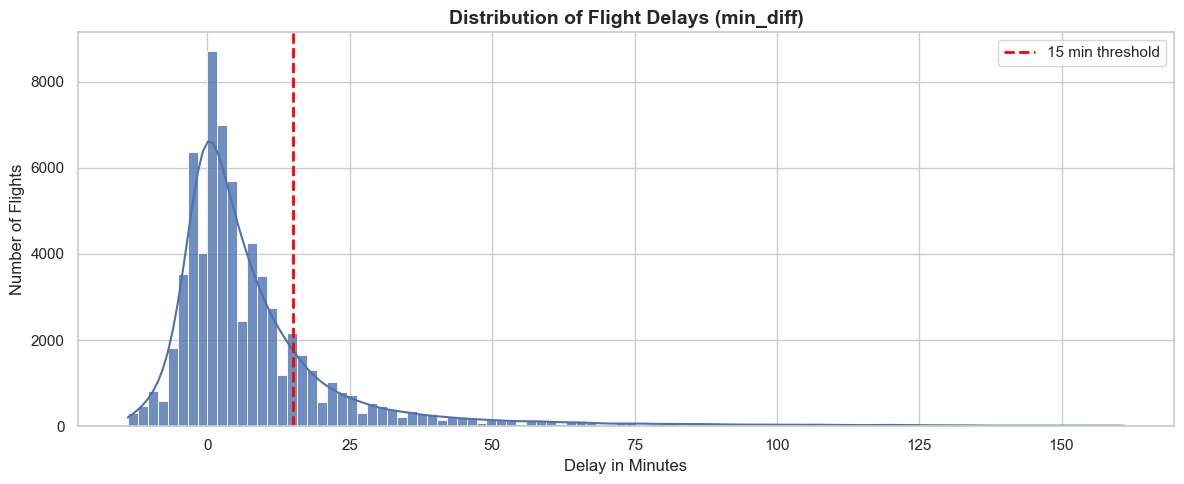

In [12]:
# Delay distribution
plot_delay_distribution(df)


c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  figsize : tuple, optional


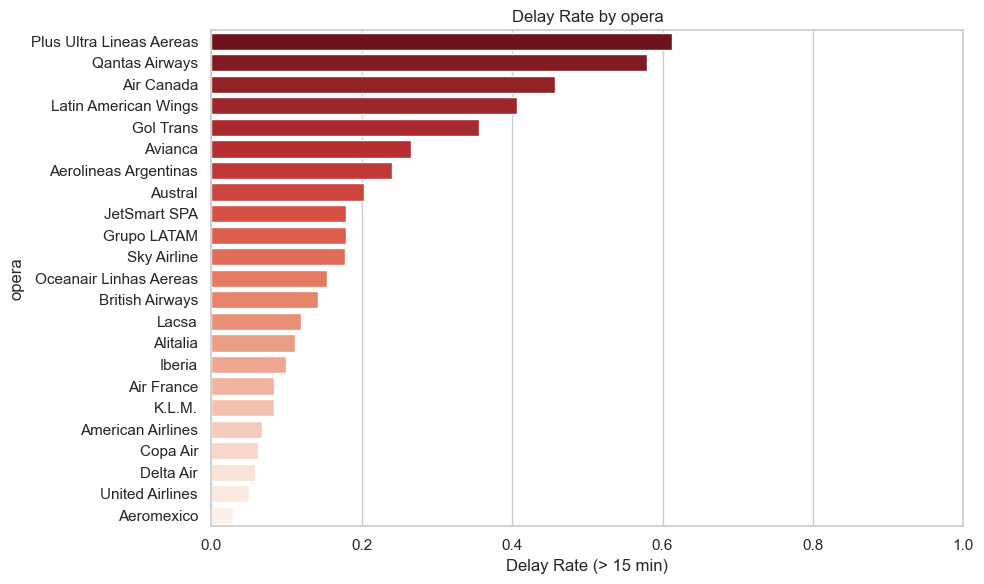

In [14]:
# Delay rate by airline
plot_delay_rate_by_column(df, "opera")


c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  figsize : tuple, optional


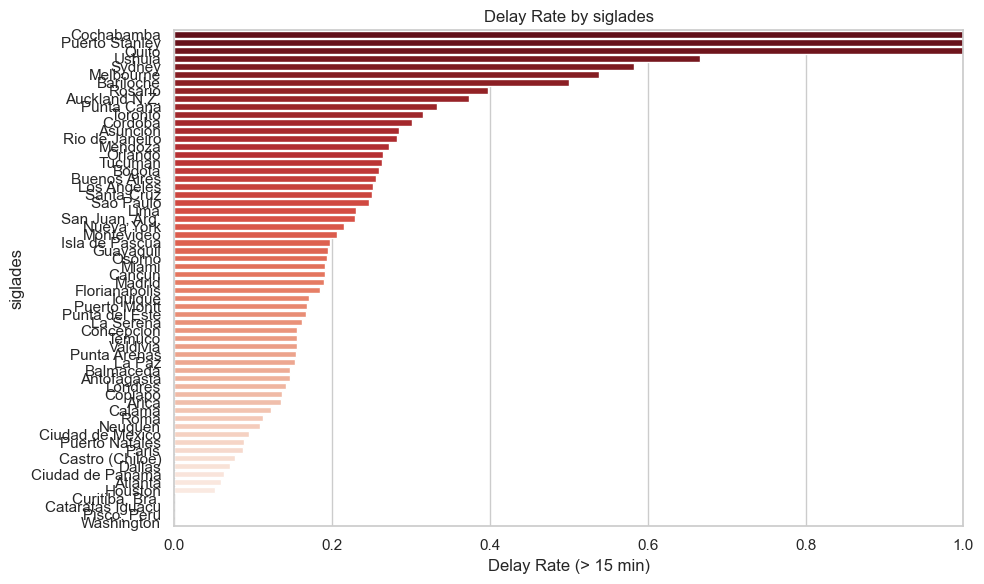

In [17]:
# Delay rate by destination
plot_delay_rate_by_column(df, "siglades")


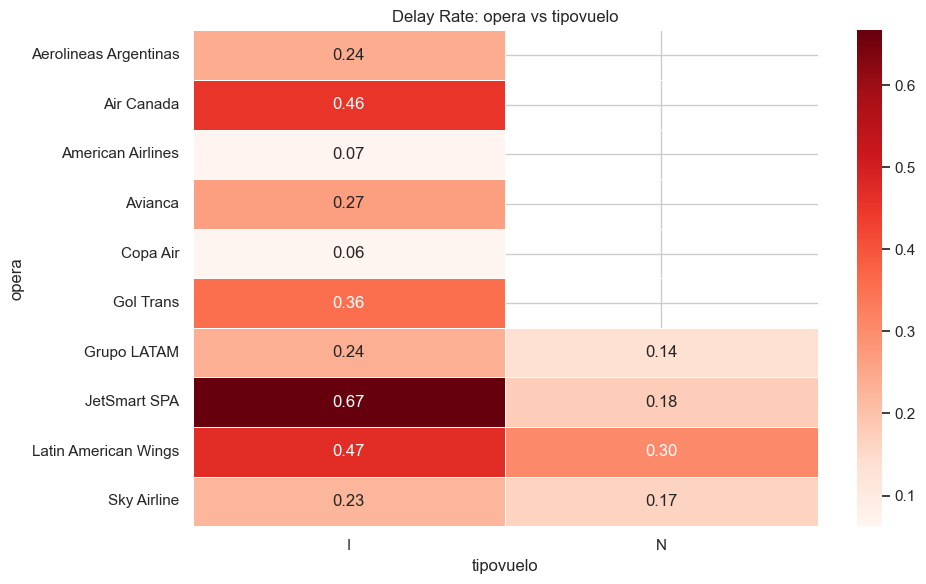

In [20]:
# Delay rate by airline and flight type
plot_delay_rate_by_two_categories(df, "opera", "tipovuelo", top_n=10)



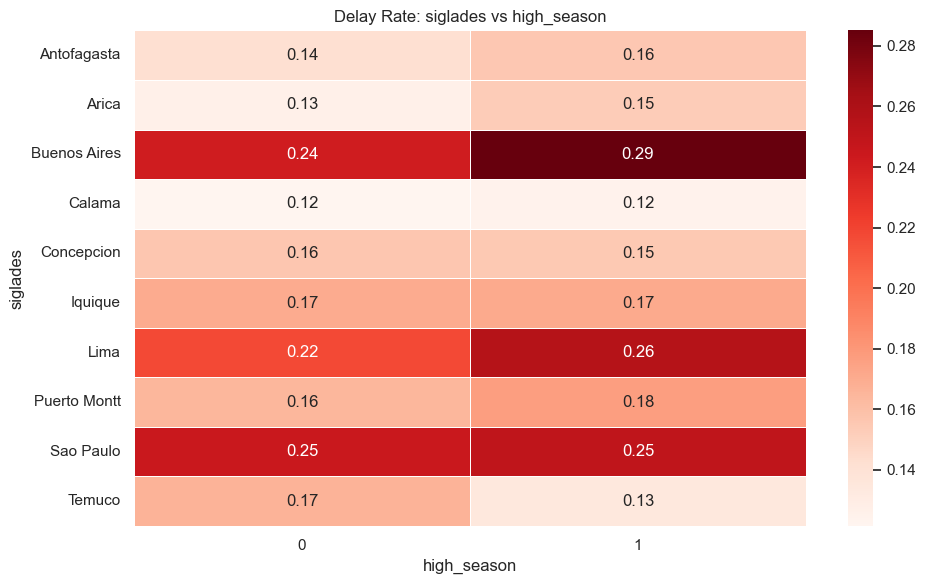

In [21]:
# Delay rate by destination and high season
plot_delay_rate_by_two_categories(df, "siglades", "high_season", top_n=10)


## 🤖 Predictive Modeling

This section will introduce supervised models (e.g., Random Forest, Logistic Regression, or XGBoost) to predict whether a flight is delayed over 15 minutes.

Models will be evaluated using classification metrics such as:
- Accuracy
- Precision / Recall
- F1-score
- ROC-AUC

In [23]:
from src.models.train_model import train_model

# Train Random Forest model
model, X_test, y_test, y_pred = train_model(df, model_type="random_forest", save_model=True)



🔍 Classification Report (random_forest):
              precision    recall  f1-score   support

           0       0.85      0.76      0.81     11118
           1       0.29      0.42      0.34      2523

    accuracy                           0.70     13641
   macro avg       0.57      0.59      0.57     13641
weighted avg       0.75      0.70      0.72     13641

📈 ROC AUC: 0.6343
💾 Model saved to: models/model.pkl


## 📉 Plot Evaluation Metrics

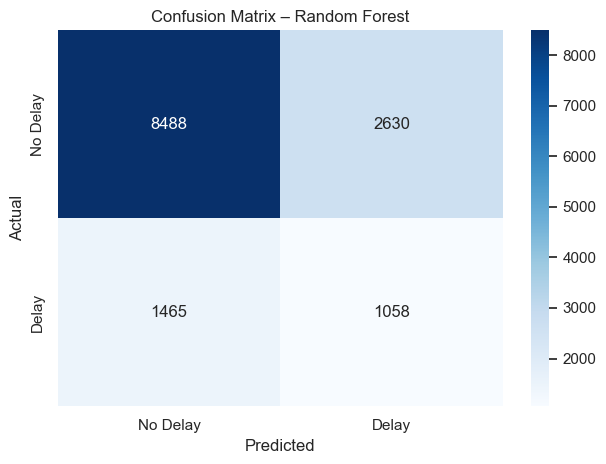

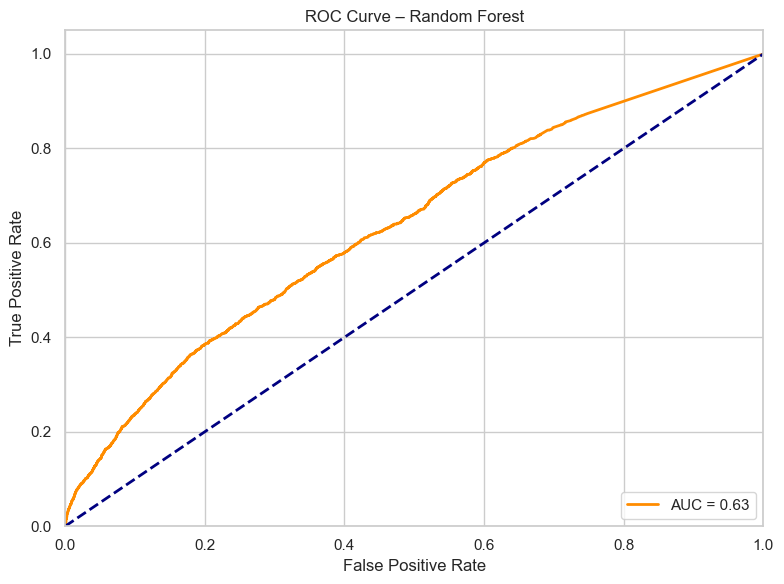

In [24]:
from src.models.evaluate_model import plot_confusion_matrix, plot_roc_curve

# Predicted probabilities for ROC
y_proba = model.predict_proba(X_test)[:, 1]

# Plot evaluation visuals
plot_confusion_matrix(y_test, y_pred, labels=["No Delay", "Delay"], title="Confusion Matrix – Random Forest")
plot_roc_curve(y_test, y_proba, title="ROC Curve – Random Forest")


## ✅ Conclusions

- Certain airlines and destinations show significantly higher delay rates.
- The `min_diff` feature captures time deviations and reveals operational issues.
- Temporal and categorical variables like `period_day`, `high_season`, and `tipovuelo` provide important segmentations.
- The problem is well-suited for a binary classification model.

## ✅ Summary & Next Steps

This notebook covered the full pipeline from data loading to model evaluation.

Key takeaways:
- Delay prediction is a feasible task using simple operational variables.
- Features like flight type, airline, time of day, and seasonality provide valuable segmentation.
- A Random Forest model achieved reasonable performance for classifying delays over 15 minutes.

### Next steps:
- Hyperparameter tuning with cross-validation
- Feature selection and dimensionality reduction
- Integration of external features (e.g., weather, traffic)
- Deployment of the model as a service (API or dashboard)

